
**A.**

The function envy_free_room_allocation_path_method
implements the "heaviest path" method for envy-free room allocation under a fixed rent constraint.

Internally, it first finds an optimal matching via the Hungarian algorithm, then calculates grants using a variant of Bellman-Ford, and finally adjusts prices so that their sum equals the rent.

To satisfy both automated doctests and human-readable output requirements, the function returns a structured list of tuples. Readable output (like in the task example) is generated in the main() block using a helper print_allocation() function.


In [11]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import networkx as nx

def envy_free_room_allocation_path_method(valuations: list[list[float]], rent: float):
    """
    >>> envy_free_room_allocation_path_method([[100, 80], [80, 100]], 180)
    [(0, 0, 100.0, 90), (1, 1, 100.0, 90)]

    >>> envy_free_room_allocation_path_method([[50, 50], [50, 50]], 100)
    [(0, 0, 50.0, 50), (1, 1, 50.0, 50)]

    >>> envy_free_room_allocation_path_method([[100, 100], [10, 10]], 110)
    [(0, 0, 100.0, 55), (1, 1, 10.0, 55)]

    >>> envy_free_room_allocation_path_method([[75]], 75)
    [(0, 0, 75.0, 75)]

    >>> envy_free_room_allocation_path_method([[70, 60], [65, 75]], 0)
    [(0, 0, 70.0, 0), (1, 1, 75.0, 0)]

    >>> envy_free_room_allocation_path_method([[30, 20], [25, 35]], 200)
    [(0, 0, 30.0, 100), (1, 1, 35.0, 100)]

    >>> envy_free_room_allocation_path_method([[40, 60], [40, 60]], 100)
    [(0, 1, 60.0, 60), (1, 0, 40.0, 40)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 70, 60],
    ...     [60, 90, 70],
    ...     [70, 60, 90]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 90.0, 80), (2, 2, 90.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 30, 60],
    ...     [70, 80, 40],
    ...     [60, 40, 100]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 80.0, 80), (2, 2, 100.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [80, 70, 60, 90],
    ...     [90, 60, 70, 80],
    ...     [70, 80, 90, 60],
    ...     [60, 90, 80, 70]], rent=360)
    [(0, 3, 90.0, 90), (1, 0, 90.0, 90), (2, 2, 90.0, 90), (3, 1, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 80, 70, 60],
    ...     [60, 90, 80, 70],
    ...     [70, 60, 90, 80],
    ...     [80, 70, 60, 90]], rent=360)
    [(0, 0, 90.0, 90), (1, 1, 90.0, 90), (2, 2, 90.0, 90), (3, 3, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([[150, 0], [140, 10]], rent=100)
    [(0, 0, 150.0, 115), (1, 1, 10.0, -15)]

    """

    num_players = len(valuations)
    valuations = np.array(valuations)
    # Step 1: Find a max value assignment using the Hungarian algorithm
    # We negate values because the algorithm minimizes cost
    cost_matrix = -valuations
    assigned_players, assigned_rooms = linear_sum_assignment(cost_matrix)
    assignments = list(zip(assigned_players, assigned_rooms))

    # Step 2: Build a directed graph where each player points to all rooms with edge weights as their valuations
    graph = nx.DiGraph()
    for player in range(num_players):
        for room in range(num_players):
            graph.add_edge(f'player{player}', f'room{room}', weight=valuations[player][room])

    # Step 3: Compute grants (how much value each player "lost" by not getting their top choice)
    player_grants = np.zeros(num_players)

    for player, room in assignments:

        best_room_value = {f'room{r}': -np.inf for r in range(num_players)}
        best_room_value[f'room{room}'] = valuations[player][room]

      # Simulate Bellman-Ford relaxation
        for _ in range(num_players - 1):
            for from_node, to_node, edge_data in graph.edges(data=True):
                if from_node == f'player{player}':
                    room_index = int(to_node.replace('room', ''))
                    value = valuations[player][room_index]
                    if best_room_value[to_node] < value:
                        best_room_value[to_node] = value

         # Grant = assigned value - best value they could have gotten
        max_other_value = max(best_room_value.values())
        actual_value = valuations[player][room]
        player_grants[player] = actual_value - max_other_value

    # Step 4: Adjust grants so the total payment equals the rent
    total_grants = np.sum(player_grants)
    correction = (total_grants - rent) / num_players
    room_prices = player_grants - correction

    results = []
    for player, room in assignments:
        value = valuations[player][room]
        payment = round(float(room_prices[player]))
        results.append((
            int(player),
            int(room),
            round(float(value), 6),
            round(float(room_prices[player]))
        ))
    return results

def print_allocation(result):
    for player, room, value, payment in result:
        print(f"Player {player} gets room {room} with value {int(value)}, and pays {payment}")


if __name__ == "__main__":
  import doctest
  doctest.testmod(verbose=True)
  examples = [
          {
              "name": "Example 1",
              "valuations": [[150, 0], [140, 10]],
              "rent": 100
          },
          {
              "name": "Example 2 - Equal preferences",
              "valuations": [[50, 50], [50, 50]],
              "rent": 100
          },
          {
              "name": "Example 3 - Clear preference",
              "valuations": [[200, 0], [180, 20]],
              "rent": 100
          },
          {
              "name": "Example 4 - Random small",
              "valuations": [[40, 60], [40, 60]],
              "rent": 100
          }
          ]

  for ex in examples:
        print(f"\n=== {ex['name']} ===")
        result = envy_free_room_allocation_path_method(ex["valuations"], ex["rent"])
        print_allocation(result)


Trying:
    envy_free_room_allocation_path_method([[100, 80], [80, 100]], 180)
Expecting:
    [(0, 0, 100.0, 90), (1, 1, 100.0, 90)]
ok
Trying:
    envy_free_room_allocation_path_method([[50, 50], [50, 50]], 100)
Expecting:
    [(0, 0, 50.0, 50), (1, 1, 50.0, 50)]
ok
Trying:
    envy_free_room_allocation_path_method([[100, 100], [10, 10]], 110)
Expecting:
    [(0, 0, 100.0, 55), (1, 1, 10.0, 55)]
ok
Trying:
    envy_free_room_allocation_path_method([[75]], 75)
Expecting:
    [(0, 0, 75.0, 75)]
ok
Trying:
    envy_free_room_allocation_path_method([[70, 60], [65, 75]], 0)
Expecting:
    [(0, 0, 70.0, 0), (1, 1, 75.0, 0)]
ok
Trying:
    envy_free_room_allocation_path_method([[30, 20], [25, 35]], 200)
Expecting:
    [(0, 0, 30.0, 100), (1, 1, 35.0, 100)]
ok
Trying:
    envy_free_room_allocation_path_method([[40, 60], [40, 60]], 100)
Expecting:
    [(0, 1, 60.0, 60), (1, 0, 40.0, 40)]
ok
Trying:
    envy_free_room_allocation_path_method([
        [90, 70, 60],
        [60, 90, 70],
        

**B.**

This function implements the envy-free room allocation using linear programming.
It first finds an optimal assignment using the Hungarian algorithm (maximizing total value).
Then it sets up a linear program that finds room prices satisfying envy-freeness constraints:
Each player must prefer their assigned room (after payment) over any other.
An additional constraint ensures the total prices equal the given rent.

In [13]:
import numpy as np
import cvxpy as cp
from scipy.optimize import linear_sum_assignment

def envy_free_lp(valuations: list[list[float]], rent: float):
    """
    >>> envy_free_room_allocation_path_method([[100, 80], [80, 100]], 180)
    [(0, 0, 100.0, 90), (1, 1, 100.0, 90)]

    >>> envy_free_room_allocation_path_method([[50, 50], [50, 50]], 100)
    [(0, 0, 50.0, 50), (1, 1, 50.0, 50)]

    >>> envy_free_room_allocation_path_method([[100, 100], [10, 10]], 110)
    [(0, 0, 100.0, 55), (1, 1, 10.0, 55)]

    >>> envy_free_room_allocation_path_method([[75]], 75)
    [(0, 0, 75.0, 75)]

    >>> envy_free_room_allocation_path_method([[70, 60], [65, 75]], 0)
    [(0, 0, 70.0, 0), (1, 1, 75.0, 0)]

    >>> envy_free_room_allocation_path_method([[30, 20], [25, 35]], 200)
    [(0, 0, 30.0, 100), (1, 1, 35.0, 100)]

    >>> envy_free_room_allocation_path_method([[40, 60], [40, 60]], 100)
    [(0, 1, 60.0, 60), (1, 0, 40.0, 40)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 70, 60],
    ...     [60, 90, 70],
    ...     [70, 60, 90]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 90.0, 80), (2, 2, 90.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 30, 60],
    ...     [70, 80, 40],
    ...     [60, 40, 100]], rent=240)
    [(0, 0, 90.0, 80), (1, 1, 80.0, 80), (2, 2, 100.0, 80)]

    >>> envy_free_room_allocation_path_method([
    ...     [80, 70, 60, 90],
    ...     [90, 60, 70, 80],
    ...     [70, 80, 90, 60],
    ...     [60, 90, 80, 70]], rent=360)
    [(0, 3, 90.0, 90), (1, 0, 90.0, 90), (2, 2, 90.0, 90), (3, 1, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([
    ...     [90, 80, 70, 60],
    ...     [60, 90, 80, 70],
    ...     [70, 60, 90, 80],
    ...     [80, 70, 60, 90]], rent=360)
    [(0, 0, 90.0, 90), (1, 1, 90.0, 90), (2, 2, 90.0, 90), (3, 3, 90.0, 90)]

    >>> envy_free_room_allocation_path_method([[150, 0], [140, 10]], rent=100)
    [(0, 0, 150.0, 115), (1, 1, 10.0, -15)]

    """
    n = len(valuations)
    valuations = np.array(valuations)

    # Step 1: Compute optimal assignment using the Hungarian algorithm
    # We maximize total value by minimizing the negative valuation matrix
    cost_matrix = -valuations
    players, rooms = linear_sum_assignment(cost_matrix)
    assignment = list(zip(players, rooms))

    # Step 2: Set up a linear program to find envy-free prices
    # Define price variable: p_j is the price for room j
    p = cp.Variable(n)

    constraints = []

    # Envy-freeness constraints:
    # For each player i assigned to room j
    # their utility must be at least as much as they would get from any other room k:
    #   v[i][j] - p[j] >= v[i][k] - p[k]
    for i, j in assignment:
        for k in range(n):
            constraints.append(valuations[i, j] - p[j] >= valuations[i, k] - p[k])

    # Add constraint: total prices must equal rent
    constraints.append(cp.sum(p) == rent)

    # Step 3: Solve the LP
    problem = cp.Problem(cp.Minimize(0), constraints)
    problem.solve()


    prices = p.value  # Solved room prices
    results = []
    for i, j in assignment:
        results.append((
            i,
            j,
            valuations[i][j],
            round(prices[j])
        ))

    return results

if __name__ == "__main__":
  import doctest
  doctest.testmod(verbose=True)

Trying:
    envy_free_room_allocation_path_method([[100, 80], [80, 100]], 180)
Expecting:
    [(0, 0, 100.0, 90), (1, 1, 100.0, 90)]
ok
Trying:
    envy_free_room_allocation_path_method([[50, 50], [50, 50]], 100)
Expecting:
    [(0, 0, 50.0, 50), (1, 1, 50.0, 50)]
ok
Trying:
    envy_free_room_allocation_path_method([[100, 100], [10, 10]], 110)
Expecting:
    [(0, 0, 100.0, 55), (1, 1, 10.0, 55)]
ok
Trying:
    envy_free_room_allocation_path_method([[75]], 75)
Expecting:
    [(0, 0, 75.0, 75)]
ok
Trying:
    envy_free_room_allocation_path_method([[70, 60], [65, 75]], 0)
Expecting:
    [(0, 0, 70.0, 0), (1, 1, 75.0, 0)]
ok
Trying:
    envy_free_room_allocation_path_method([[30, 20], [25, 35]], 200)
Expecting:
    [(0, 0, 30.0, 100), (1, 1, 35.0, 100)]
ok
Trying:
    envy_free_room_allocation_path_method([[40, 60], [40, 60]], 100)
Expecting:
    [(0, 1, 60.0, 60), (1, 0, 40.0, 40)]
ok
Trying:
    envy_free_room_allocation_path_method([
        [90, 70, 60],
        [60, 90, 70],
        

This part compares the runtime of the two methods for envy-free room allocation:

* For each input size n (number of players and rooms), it generates a random n × n valuation matrix and a random rent.
* Then it measures the execution time of each method using time.perf_counter().

* The function compare_allocation_methods returns lists of runtimes for both methods, which are then plotted using Matplotlib.
This visualization shows how the performance of each method scales with the number of players/rooms.

* Conclusion: The path-based method is significantly faster and scales better than the LP-based method, especially as the input size grows.

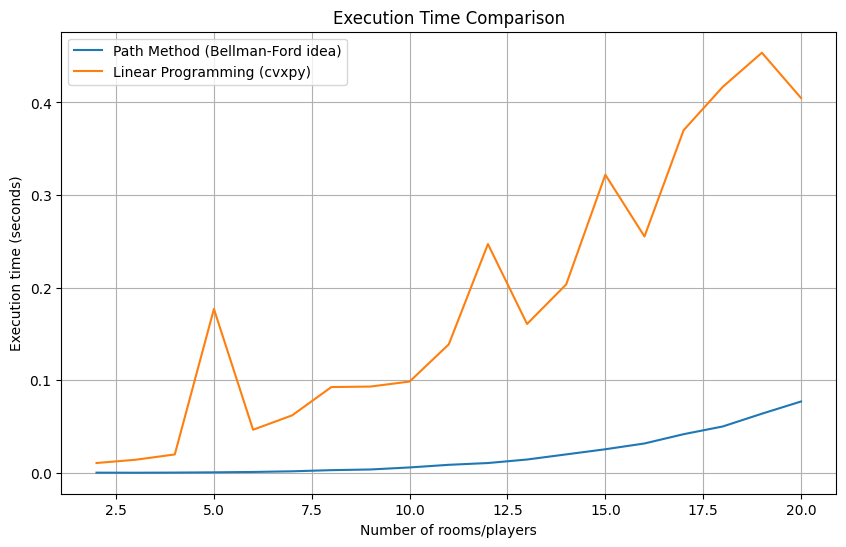

In [7]:
import time
import numpy as np
import matplotlib.pyplot as plt

def compare_allocation_methods(sizes):
    """
    Compare the execution time of the path-based method and the LP-based method
    for different numbers of players/rooms.

    Parameters:
        sizes (list[int]): List of input sizes (n = number of players/rooms)

    Returns:
        tuple: (sizes, path_times, lp_times)
    """
    path_times = []
    lp_times = []

    for n in sizes:
        # Generate random valuation matrix of size n x n
        valuations = np.random.randint(0, 100, size=(n, n)).tolist()
        rent = int(np.random.uniform(50, 150) * n)  # random rent per player

        # Time the path-based method
        start = time.perf_counter()
        envy_free_room_allocation_path_method(valuations, rent)
        path_times.append(time.perf_counter() - start)

        # Time the LP-based method
        start = time.perf_counter()
        envy_free_lp(valuations, rent)
        lp_times.append(time.perf_counter() - start)

    return sizes, path_times, lp_times

# Compare for input sizes from 2 to 20
sizes = list(range(2, 21))
sizes, path_times, lp_times = compare_allocation_methods(sizes)

plt.figure(figsize=(10, 6))
plt.plot(sizes, path_times, label="Path Method", marker='o')
plt.plot(sizes, lp_times, label="LP Method (cvxpy)", marker='s')
plt.xlabel("Number of rooms/players (n)")
plt.ylabel("Execution time (seconds)")
plt.title("Runtime Comparison: Path-Based vs LP-Based Envy-Free Allocation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
